Searching for images in: 'train_processed'
Found 889366 total images. Selecting 4 to display.


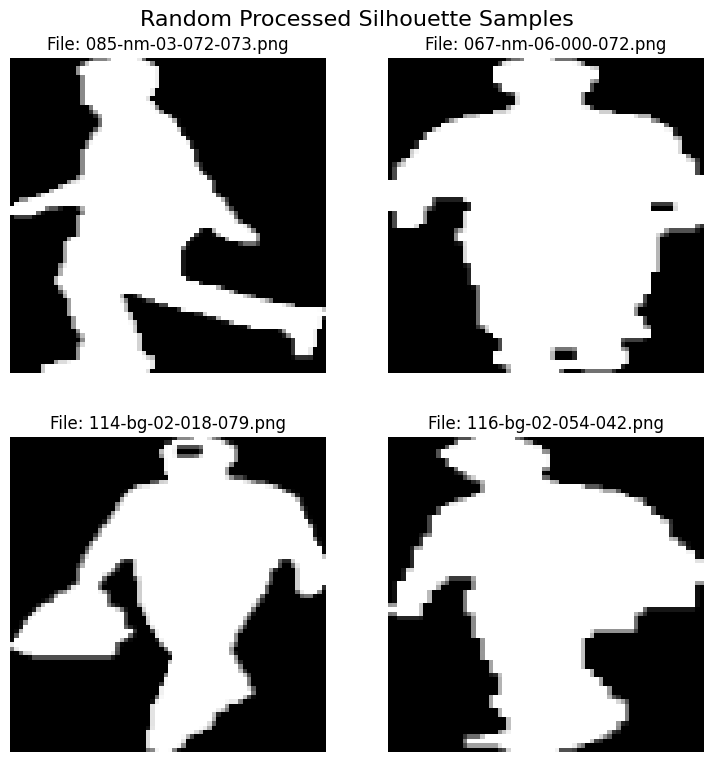

In [4]:
import os
import random
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 1. Path to the directory containing your PROCESSED images.
PROCESSED_DATA_DIR = 'train_processed' 

# 2. Number of images to display at once. 4 will create a 2x2 grid.
NUM_IMAGES_TO_SHOW = 4


def visualize_processed_data():
    """
    Selects random processed images, parses their filenames, and displays them
    with descriptive titles in a grid.
    """
    print(f"Searching for images in: '{PROCESSED_DATA_DIR}'")

    # Check if the directory exists
    if not os.path.isdir(PROCESSED_DATA_DIR):
        print(f"Error: Directory not found at '{PROCESSED_DATA_DIR}'.")
        print("Please make sure you have run the preprocessing script and the")
        print(" 'train_processed' and/or 'validation_processed' folders exist.")
        return

    # Find all .png image files recursively in the directory
    all_image_paths = glob.glob(os.path.join(PROCESSED_DATA_DIR, '**', '*.png'), recursive=True)

    if not all_image_paths:
        print(f"Error: No images found in '{PROCESSED_DATA_DIR}'.")
        return
    
    print(f"Found {len(all_image_paths)} total images. Selecting {NUM_IMAGES_TO_SHOW} to display.")

    # Randomly select a sample of images
    selected_paths = random.sample(all_image_paths, min(NUM_IMAGES_TO_SHOW, len(all_image_paths)))

    # Create a plot to display the images. We'll make a 2x2 grid for 4 images.
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

    for i, img_path in enumerate(selected_paths):
        # 1. Read the image
        img = mpimg.imread(img_path)
        
        # 2. Parse the filename to get details. E.g., '001-nm-01-090.png'
        filename = os.path.basename(img_path)
        parts = filename.replace('.png', '').split('-')
        
        title = f"File: {filename}" # Default title
        if len(parts) == 4:
            subject_id, condition, sequence, angle = parts
            title = f"Subject: {subject_id}\nType: {condition}-{sequence}, Angle: {angle}"
        
        # 3. Display the image on its subplot
        ax = axes[i]
        ax.imshow(img, cmap='gray') # Use a grayscale colormap
        ax.set_title(title)
        ax.axis('off') # Hide the x and y axis ticks for a cleaner look

    # Hide any unused subplots if NUM_IMAGES_TO_SHOW is less than 4
    for j in range(len(selected_paths), len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=3.0)
    fig.suptitle('Random Processed Silhouette Samples', fontsize=16)
    plt.show()

if __name__ == '__main__':
    visualize_processed_data()


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import time
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# --- Configuration ---
DATA_DIR = '.' 
NUM_SUBJECTS_TO_TRAIN = 123

# --- Model & Training Parameters ---
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

# --- NEW: Definition of a Simple CNN Model ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 3 x 72 x 72
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 16 x 36 x 36

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Output: 32 x 18 x 18

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            # Output: 64 x 9 x 9
        )
        # Fully connected layers (classifier)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 9 * 9, 512), # 64 channels * 9x9 image size
            nn.ReLU(),
            nn.Linear(512, num_classes) # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

def train_gait_model():
    """
    Main function to set up the dataset, build the model, and run the training loop.
    MODIFIED: Now returns training history for plotting.
    """
    print(f"Initializing OPTIMIZED training process for {NUM_CLASSES} subjects...")

    # --- YOUR ORIGINAL CODE (unchanged until training loop) ---
    # [All data loading, transforms, model setup code remains EXACTLY the same]
    
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        'validation': transforms.Compose([
            transforms.Resize((72, 72)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
    }

    train_dir = os.path.join(DATA_DIR, 'train_processed')
    validation_dir = os.path.join(DATA_DIR, 'validation_processed')
    
    full_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
    }
    
    if NUM_SUBJECTS_TO_TRAIN is not None:
        all_classes = sorted(full_datasets['train'].classes)
        subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
        class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
        
        for phase in ['train', 'validation']:
            full_dataset = full_datasets[phase]
            new_samples = []
            for path, old_idx in full_dataset.samples:
                class_name = all_classes[old_idx]
                if class_name in class_to_idx_subset:
                     new_samples.append((path, class_to_idx_subset[class_name]))
            
            full_datasets[phase].samples = new_samples
            full_datasets[phase].classes = subset_classes
            full_datasets[phase].class_to_idx = class_to_idx_subset
            full_datasets[phase].targets = [s[1] for s in new_samples]

    dataloaders = {
        'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
        'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
    }

    dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
    print(f"Training data size: {dataset_sizes['train']}")
    print(f"Validation data size: {dataset_sizes['validation']}")

    model = SimpleCNN(num_classes=NUM_CLASSES)
    print("Using SimpleCNN model for this training run.")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training will use device: {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scaler = GradScaler()
    use_amp = torch.cuda.is_available()

    # --- NEW: Lists to store metrics for plotting ---
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    start_time = time.time()
    print("\nStarting model training...")

    for epoch in range(NUM_EPOCHS):
        print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
        print('-' * 10)

        for phase in ['train', 'validation']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')
            
            for inputs, labels in progress_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad(set_to_none=True)

                with autocast(enabled=use_amp):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # --- NEW: Store metrics ---
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu().item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu().item())

    time_elapsed = time.time() - start_time
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    
    # --- NEW: Return metrics for plotting ---
    return model, train_losses, val_losses, train_accs, val_accs, full_datasets['validation']


In [6]:
# Cell 1 - This CALLS the function and stores results
model, train_losses, val_losses, train_accs, val_accs, val_dataset = train_gait_model()
print("Training completed! Metrics collected for plotting.")


Initializing OPTIMIZED training process for 123 subjects...
Training data size: 889366
Validation data size: 222404
Using SimpleCNN model for this training run.
Training will use device: cuda:0


C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\1544628390.py:124: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Starting model training...
Epoch 1/10
----------


Train Phase:   0%|          | 0/27793 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\1544628390.py:151: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Train Phase: 100%|██████████| 27793/27793 [06:06<00:00, 75.81it/s] 


Train Loss: 0.8612 Acc: 0.7652


Validation Phase: 100%|██████████| 6951/6951 [01:23<00:00, 83.18it/s] 


Validation Loss: 0.4146 Acc: 0.8786
Epoch 2/10
----------


Train Phase: 100%|██████████| 27793/27793 [05:38<00:00, 82.11it/s] 


Train Loss: 0.3385 Acc: 0.8993


Validation Phase: 100%|██████████| 6951/6951 [01:32<00:00, 75.50it/s] 


Validation Loss: 0.3155 Acc: 0.9076
Epoch 3/10
----------


Train Phase: 100%|██████████| 27793/27793 [06:14<00:00, 74.18it/s] 


Train Loss: 0.2479 Acc: 0.9249


Validation Phase: 100%|██████████| 6951/6951 [01:42<00:00, 67.63it/s] 


Validation Loss: 0.2832 Acc: 0.9170
Epoch 4/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:57<00:00, 93.50it/s] 


Train Loss: 0.2038 Acc: 0.9375


Validation Phase: 100%|██████████| 6951/6951 [01:13<00:00, 94.09it/s] 


Validation Loss: 0.2820 Acc: 0.9193
Epoch 5/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:36<00:00, 100.45it/s]


Train Loss: 0.1777 Acc: 0.9451


Validation Phase: 100%|██████████| 6951/6951 [01:13<00:00, 94.05it/s] 


Validation Loss: 0.3120 Acc: 0.9191
Epoch 6/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:37<00:00, 100.05it/s]


Train Loss: 0.1576 Acc: 0.9512


Validation Phase: 100%|██████████| 6951/6951 [01:13<00:00, 94.41it/s] 


Validation Loss: 0.2736 Acc: 0.9274
Epoch 7/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:36<00:00, 100.67it/s]


Train Loss: 0.1444 Acc: 0.9554


Validation Phase: 100%|██████████| 6951/6951 [01:13<00:00, 94.13it/s] 


Validation Loss: 0.2657 Acc: 0.9322
Epoch 8/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:35<00:00, 100.88it/s]


Train Loss: 0.1331 Acc: 0.9589


Validation Phase: 100%|██████████| 6951/6951 [01:17<00:00, 90.06it/s] 


Validation Loss: 0.2935 Acc: 0.9282
Epoch 9/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:42<00:00, 98.52it/s] 


Train Loss: 0.1271 Acc: 0.9610


Validation Phase: 100%|██████████| 6951/6951 [01:16<00:00, 90.97it/s] 


Validation Loss: 0.2954 Acc: 0.9301
Epoch 10/10
----------


Train Phase: 100%|██████████| 27793/27793 [04:44<00:00, 97.56it/s] 


Train Loss: 0.1214 Acc: 0.9628


Validation Phase: 100%|██████████| 6951/6951 [01:16<00:00, 90.33it/s] 

Validation Loss: 0.2884 Acc: 0.9319

Training complete in 64m 14s
Training completed! Metrics collected for plotting.


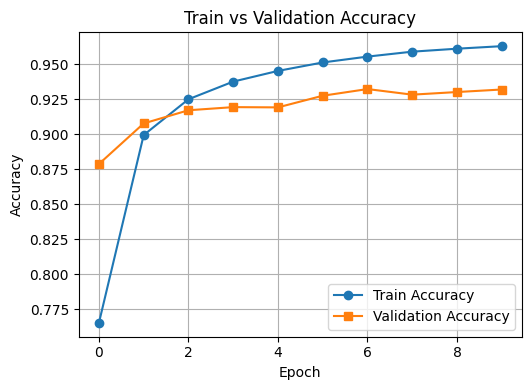

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='s')
plt.title('Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


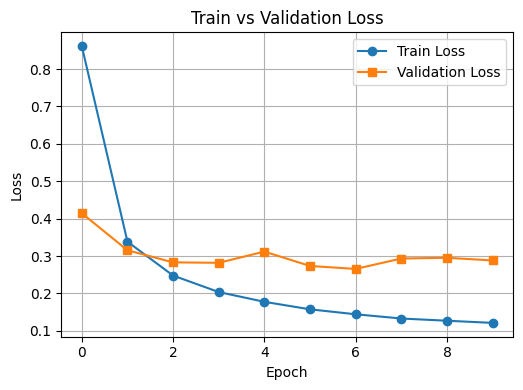

In [8]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Get predictions on validation set
device = next(model.parameters()).device
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print(f"Confusion Matrix shape: {cm.shape}")


Confusion Matrix shape: (123, 123)


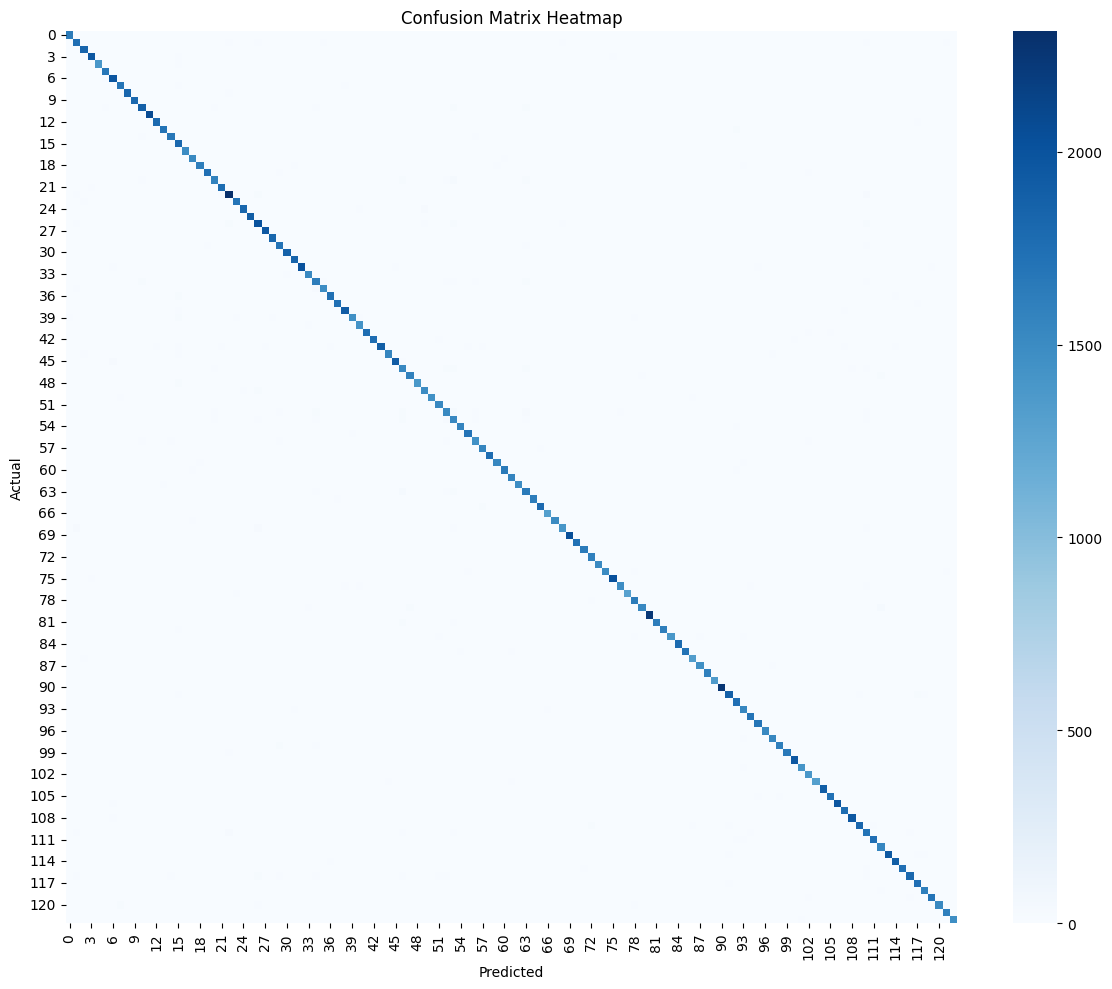

Classes shown (first 10): ['001', '002', '003', '004', '006', '007', '008', '009', '010', '011']


In [10]:
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Show class names (first 10 for readability if too many classes)
class_names = val_dataset.classes[:min(10, len(val_dataset.classes))]
print("Classes shown (first 10):", class_names)


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
import sys
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

DATA_DIR = '.' 
NUM_SUBJECTS_TO_TRAIN = 123 
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

class XceptionTrainer:
    def train_gait_model(self):
        """
        Main function to set up the dataset, build the model, and run the training loop.
        MODIFIED: Now returns training history for plotting.
        """
        print(f"Initializing OPTIMIZED Xception training for {NUM_CLASSES} subjects...")

        # --- YOUR ORIGINAL CODE (unchanged until training loop) ---
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
            'validation': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
        }

        train_dir = os.path.join(DATA_DIR, 'train_processed')
        validation_dir = os.path.join(DATA_DIR, 'validation_processed')

        print(f"Loading data from source directories...")
        
        full_datasets = {
            'train': datasets.ImageFolder(train_dir, data_transforms['train']),
            'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
        }
        
        if NUM_SUBJECTS_TO_TRAIN is not None:
            print(f"Filtering dataset to the first {NUM_SUBJECTS_TO_TRAIN} subjects...")
            
            all_classes = sorted(full_datasets['train'].classes)
            subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
            
            class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
            
            for phase in ['train', 'validation']:
                full_dataset = full_datasets[phase]
                new_samples = []
                for path, old_idx in full_dataset.samples:
                    class_name = all_classes[old_idx]
                    if class_name in class_to_idx_subset:
                         new_samples.append((path, class_to_idx_subset[class_name]))
                
                full_datasets[phase].samples = new_samples
                full_datasets[phase].classes = subset_classes
                full_datasets[phase].class_to_idx = class_to_idx_subset
                full_datasets[phase].targets = [s[1] for s in new_samples]

        dataloaders = {
            'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
            'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
        }

        dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
        print(f"Training data size: {dataset_sizes['train']}")
        print(f"Validation data size: {dataset_sizes['validation']}")

        # Xception model
        model_Xcpetion = timm.create_model('xception', pretrained=True, num_classes=NUM_CLASSES)
        print("Xception model loaded via TIMM.")
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Training will use device: {device}")
        model = model_Xcpetion.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        scaler = GradScaler()
        use_amp = torch.cuda.is_available()

        # --- NEW: Lists to store metrics ---
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        start_time = time.time()
        print("\nStarting Xception training...")

        for epoch in range(NUM_EPOCHS):
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
            print('-' * 10)

            for phase in ['train', 'validation']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Phase')
                
                for inputs, labels in progress_bar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad(set_to_none=True)

                    with autocast(enabled=use_amp):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # --- NEW: Store metrics ---
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.cpu().item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.cpu().item())

        time_elapsed = time.time() - start_time
        print(f"\nXception Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        
        # --- NEW: Return metrics ---
        return model, train_losses, val_losses, train_accs, val_accs, full_datasets['validation']

# Run training
if __name__ == '__main__':
    trainer = XceptionTrainer()
    model, train_losses, val_losses, train_accs, val_accs, val_dataset = trainer.train_gait_model()
    print("Xception Training completed! Metrics ready for plotting.")


Initializing OPTIMIZED Xception training for 123 subjects...
Loading data from source directories...
Filtering dataset to the first 123 subjects...
Training data size: 889366
Validation data size: 222404


C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\3793940986.py:97: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Xception model loaded via TIMM.
Training will use device: cuda:0

Starting Xception training...
Epoch 1/10
----------


Train Phase:   0%|          | 0/27793 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\3793940986.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Train Phase: 100%|██████████| 27793/27793 [35:57<00:00, 12.88it/s]


Train Loss: 0.8578 Acc: 0.7644


Validation Phase: 100%|██████████| 6951/6951 [03:06<00:00, 37.36it/s]


Validation Loss: 0.2004 Acc: 0.9384
Epoch 2/10
----------


Train Phase: 100%|██████████| 27793/27793 [32:32<00:00, 14.24it/s]


Train Loss: 0.1803 Acc: 0.9443


Validation Phase: 100%|██████████| 6951/6951 [03:09<00:00, 36.60it/s]


Validation Loss: 0.1199 Acc: 0.9624
Epoch 3/10
----------


Train Phase: 100%|██████████| 27793/27793 [31:26<00:00, 14.73it/s]


Train Loss: 0.1080 Acc: 0.9661


Validation Phase: 100%|██████████| 6951/6951 [03:05<00:00, 37.53it/s]


Validation Loss: 0.0875 Acc: 0.9733
Epoch 4/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:09<00:00, 15.36it/s]


Train Loss: 0.0765 Acc: 0.9758


Validation Phase: 100%|██████████| 6951/6951 [03:05<00:00, 37.51it/s]


Validation Loss: 0.0695 Acc: 0.9789
Epoch 5/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:06<00:00, 15.39it/s]


Train Loss: 0.0587 Acc: 0.9810


Validation Phase: 100%|██████████| 6951/6951 [03:10<00:00, 36.52it/s]


Validation Loss: 0.0604 Acc: 0.9820
Epoch 6/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:09<00:00, 15.36it/s]


Train Loss: 0.0474 Acc: 0.9845


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.63it/s]


Validation Loss: 0.0581 Acc: 0.9827
Epoch 7/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:04<00:00, 15.40it/s]


Train Loss: 0.0398 Acc: 0.9872


Validation Phase: 100%|██████████| 6951/6951 [03:05<00:00, 37.55it/s]


Validation Loss: 0.0508 Acc: 0.9848
Epoch 8/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:22<00:00, 15.25it/s]


Train Loss: 0.0344 Acc: 0.9888


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.70it/s]


Validation Loss: 0.0589 Acc: 0.9836
Epoch 9/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:16<00:00, 15.30it/s]


Train Loss: 0.0303 Acc: 0.9903


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.72it/s]


Validation Loss: 0.0544 Acc: 0.9847
Epoch 10/10
----------


Train Phase: 100%|██████████| 27793/27793 [30:25<00:00, 15.22it/s] 


Train Loss: 0.0270 Acc: 0.9913


Validation Phase: 100%|██████████| 6951/6951 [03:04<00:00, 37.70it/s]


Validation Loss: 0.0472 Acc: 0.9868

Xception Training complete in 342m 31s
Xception Training completed! Metrics ready for plotting.


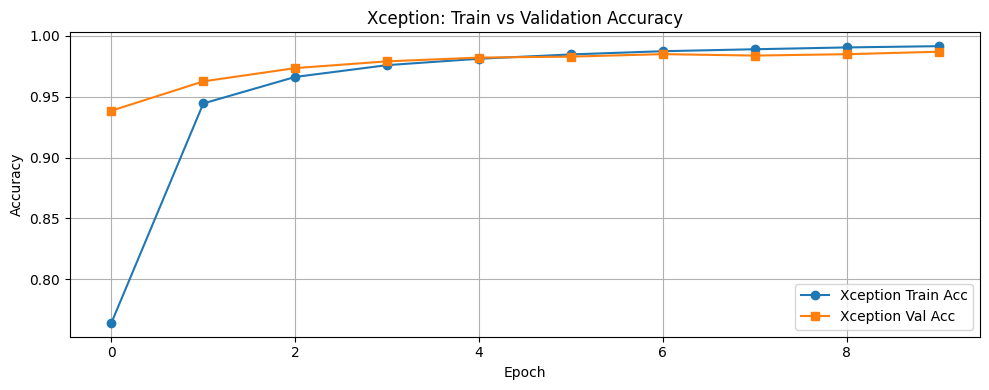

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='Xception Train Acc', marker='o')
plt.plot(val_accs, label='Xception Val Acc', marker='s')
plt.title('Xception: Train vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


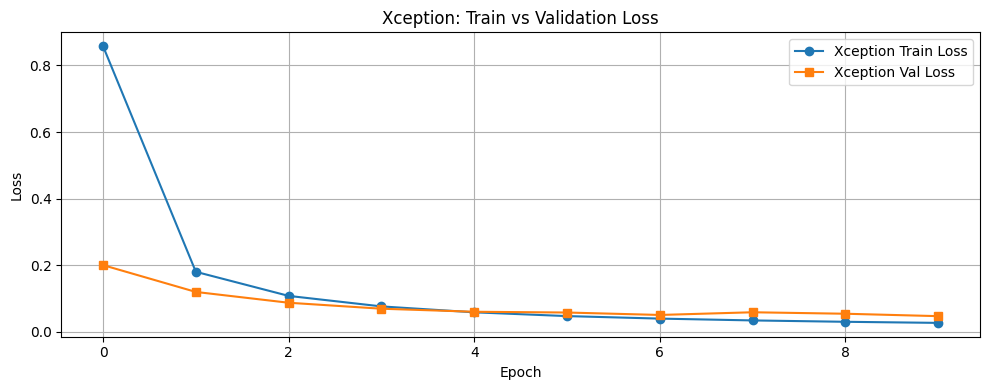

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Xception Train Loss', marker='o')
plt.plot(val_losses, label='Xception Val Loss', marker='s')
plt.title('Xception: Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
device = next(model.parameters()).device
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(f"Xception Confusion Matrix shape: {cm.shape}")


Xception Confusion Matrix shape: (123, 123)


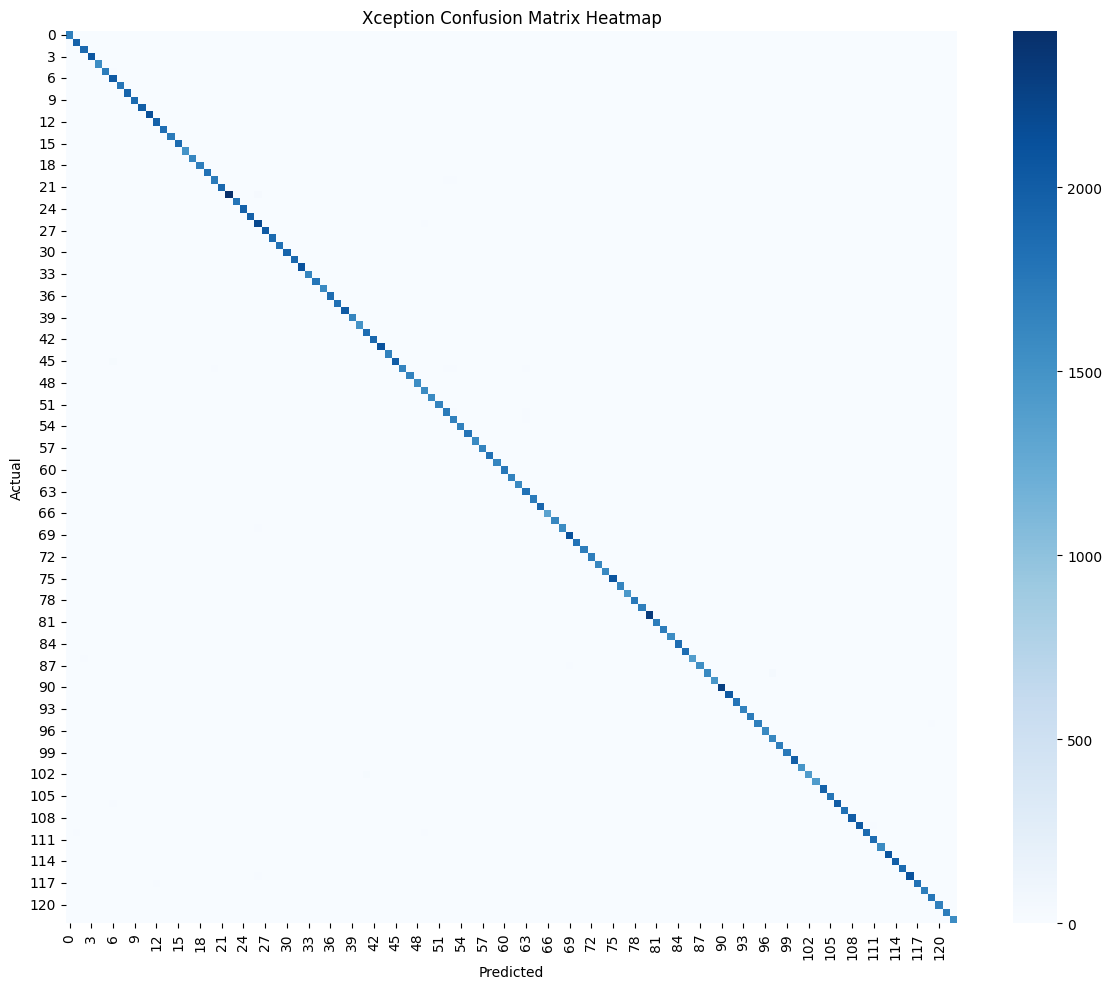

Xception Classes (first 10): ['001', '002', '003', '004', '006', '007', '008', '009', '010', '011']


In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('Xception Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

class_names = val_dataset.classes[:min(10, len(val_dataset.classes))]
print("Xception Classes (first 10):", class_names)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import os
import time
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

DATA_DIR = '.' 
NUM_SUBJECTS_TO_TRAIN = 123 
NUM_CLASSES = NUM_SUBJECTS_TO_TRAIN if NUM_SUBJECTS_TO_TRAIN is not None else 123
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

class ResNetTrainer:
    def train_gait_model(self):
        """
        ResNet model training with metric collection for plotting.
        """
        print(f"Initializing ResNet training for {NUM_CLASSES} subjects...")

        # Data transforms (same as before)
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
            'validation': transforms.Compose([
                transforms.Resize((72, 72)),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
            ]),
        }

        train_dir = os.path.join(DATA_DIR, 'train_processed')
        validation_dir = os.path.join(DATA_DIR, 'validation_processed')

        full_datasets = {
            'train': datasets.ImageFolder(train_dir, data_transforms['train']),
            'validation': datasets.ImageFolder(validation_dir, data_transforms['validation'])
        }
        
        # Filter to subset of subjects
        if NUM_SUBJECTS_TO_TRAIN is not None:
            all_classes = sorted(full_datasets['train'].classes)
            subset_classes = all_classes[:NUM_SUBJECTS_TO_TRAIN]
            class_to_idx_subset = {cls_name: i for i, cls_name in enumerate(subset_classes)}
            
            for phase in ['train', 'validation']:
                full_dataset = full_datasets[phase]
                new_samples = []
                for path, old_idx in full_dataset.samples:
                    class_name = all_classes[old_idx]
                    if class_name in class_to_idx_subset:
                        new_samples.append((path, class_to_idx_subset[class_name]))
                
                full_datasets[phase].samples = new_samples
                full_datasets[phase].classes = subset_classes
                full_datasets[phase].class_to_idx = class_to_idx_subset
                full_datasets[phase].targets = [s[1] for s in new_samples]

        dataloaders = {
            'train': DataLoader(full_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True),
            'validation': DataLoader(full_datasets['validation'], batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)
        }

        dataset_sizes = {x: len(full_datasets[x]) for x in ['train', 'validation']}
        print(f"Training data size: {dataset_sizes['train']}")
        print(f"Validation data size: {dataset_sizes['validation']}")

        # --- RESNET MODEL via TIMM ---
        model_ResNet = timm.create_model('resnet50', pretrained=True, num_classes=NUM_CLASSES)
        print("ResNet50 model loaded via TIMM.")
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Training on: {device}")
        model = model_ResNet.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        scaler = GradScaler()
        use_amp = torch.cuda.is_available()

        # Metric storage
        train_losses, val_losses = [], []
        train_accs, val_accs = [], []

        start_time = time.time()
        print("\nStarting ResNet50 training...")

        for epoch in range(NUM_EPOCHS):
            print(f'Epoch {epoch+1}/{NUM_EPOCHS}')
            print('-' * 10)

            for phase in ['train', 'validation']:
                model.train() if phase == 'train' else model.eval()

                running_loss = 0.0
                running_corrects = 0

                progress_bar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()}')
                
                for inputs, labels in progress_bar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad(set_to_none=True)

                    with autocast(enabled=use_amp):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.cpu().item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.cpu().item())

        time_elapsed = time.time() - start_time
        print(f"\nResNet50 Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
        
        return model, train_losses, val_losses, train_accs, val_accs, full_datasets['validation']

# EXECUTE TRAINING
trainer = ResNetTrainer()
model, train_losses, val_losses, train_accs, val_accs, val_dataset = trainer.train_gait_model()
print(" ResNet50 Training done! Ready for plots.")


Initializing ResNet training for 123 subjects...
Training data size: 889366
Validation data size: 222404


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
d:\Study\Coding\Project\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\swaya\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: http

ResNet50 model loaded via TIMM.
Training on: cuda:0

Starting ResNet50 training...
Epoch 1/10
----------


Train:   0%|          | 0/27793 [00:00<?, ?it/s]C:\Users\swaya\AppData\Local\Temp\ipykernel_10324\1048370785.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):
Train: 100%|██████████| 27793/27793 [29:17<00:00, 15.82it/s]


Train Loss: 0.4505 Acc: 0.8730


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.24it/s]


Validation Loss: 0.1156 Acc: 0.9640
Epoch 2/10
----------


Train: 100%|██████████| 27793/27793 [29:17<00:00, 15.81it/s]


Train Loss: 0.1000 Acc: 0.9687


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.21it/s]


Validation Loss: 0.0745 Acc: 0.9772
Epoch 3/10
----------


Train: 100%|██████████| 27793/27793 [29:22<00:00, 15.77it/s]


Train Loss: 0.0620 Acc: 0.9801


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.08it/s]


Validation Loss: 0.0593 Acc: 0.9818
Epoch 4/10
----------


Train: 100%|██████████| 27793/27793 [29:17<00:00, 15.81it/s]


Train Loss: 0.0452 Acc: 0.9854


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.22it/s]


Validation Loss: 0.0569 Acc: 0.9831
Epoch 5/10
----------


Train: 100%|██████████| 27793/27793 [30:10<00:00, 15.35it/s]


Train Loss: 0.0361 Acc: 0.9884


Validation: 100%|██████████| 6951/6951 [02:42<00:00, 42.74it/s]


Validation Loss: 0.0556 Acc: 0.9838
Epoch 6/10
----------


Train: 100%|██████████| 27793/27793 [30:17<00:00, 15.29it/s]


Train Loss: 0.0299 Acc: 0.9902


Validation: 100%|██████████| 6951/6951 [02:41<00:00, 42.96it/s]


Validation Loss: 0.0548 Acc: 0.9845
Epoch 7/10
----------


Train: 100%|██████████| 27793/27793 [29:49<00:00, 15.53it/s]


Train Loss: 0.0257 Acc: 0.9918


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.03it/s]


Validation Loss: 0.0500 Acc: 0.9864
Epoch 8/10
----------


Train: 100%|██████████| 27793/27793 [29:25<00:00, 15.74it/s]  


Train Loss: 0.0230 Acc: 0.9927


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.11it/s]


Validation Loss: 0.0459 Acc: 0.9876
Epoch 9/10
----------


Train: 100%|██████████| 27793/27793 [29:23<00:00, 15.76it/s]


Train Loss: 0.0207 Acc: 0.9934


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.23it/s]


Validation Loss: 0.0448 Acc: 0.9883
Epoch 10/10
----------


Train: 100%|██████████| 27793/27793 [29:34<00:00, 15.66it/s]  


Train Loss: 0.0194 Acc: 0.9939


Validation: 100%|██████████| 6951/6951 [02:37<00:00, 44.21it/s]


Validation Loss: 0.0477 Acc: 0.9876

ResNet50 Training complete in 322m 20s
 ResNet50 Training done! Ready for plots.


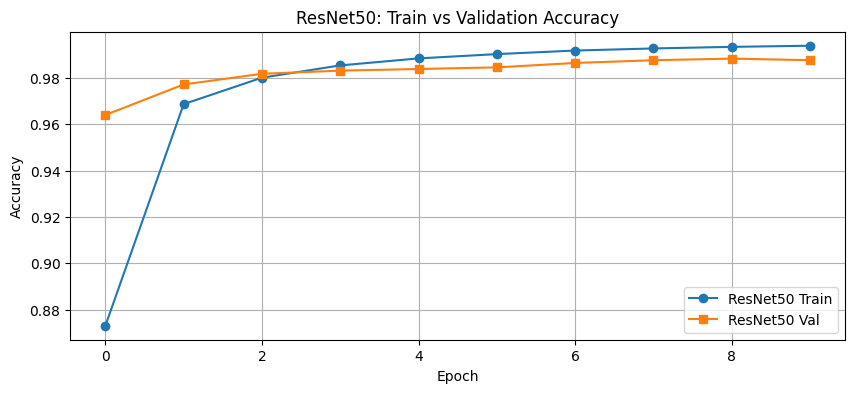

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(train_accs, label='ResNet50 Train', marker='o')
plt.plot(val_accs, label='ResNet50 Val', marker='s')
plt.title('ResNet50: Train vs Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.grid(True)
plt.show()


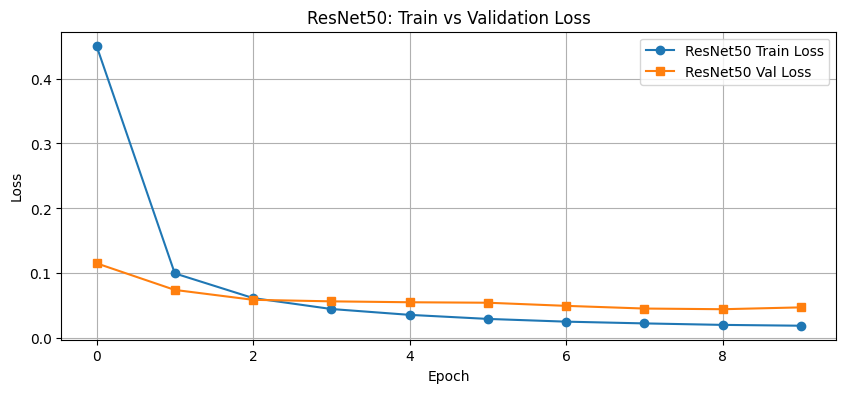

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='ResNet50 Train Loss', marker='o')
plt.plot(val_losses, label='ResNet50 Val Loss', marker='s')
plt.title('ResNet50: Train vs Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.legend(); plt.grid(True)
plt.show()


In [21]:
device = next(model.parameters()).device
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
print(f"ResNet50 CM shape: {cm.shape}")


ResNet50 CM shape: (123, 123)


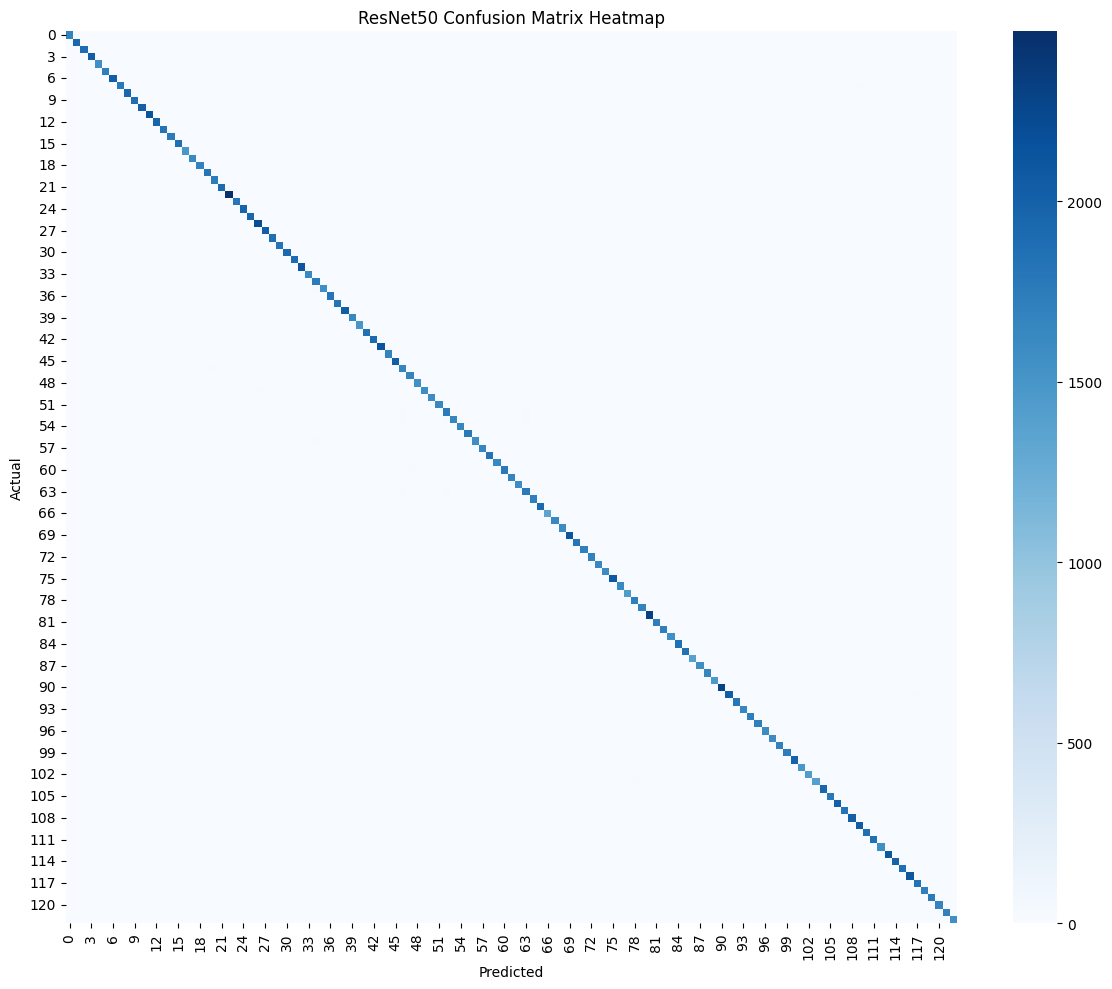

ResNet50 Classes (first 10): ['001', '002', '003', '004', '006', '007', '008', '009', '010', '011']


In [22]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', cbar=True)
plt.title('ResNet50 Confusion Matrix Heatmap')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.tight_layout()
plt.show()

print("ResNet50 Classes (first 10):", val_dataset.classes[:10])
